In [1]:
import gym
import MCTSnet
import copy

In [2]:
env = gym.make("SokobanEnc-v0")

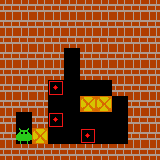

In [3]:
env.render()

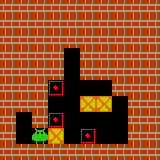

In [4]:
res = env.step(3)
env.render()